# Example `Dysmalpy` 2D fitting

**Includes the following components:**
 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

#### First import modules

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

##### Setup notebook

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [3]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

#### Set data, output paths

In [4]:
# Data directory
data_dir = '/Users/sedona/data/dysmalpy_example_data/'
#'/YOUR/DATA/PATH/'

# Where to save output files
#outdir  = './output_2D/'
outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_2D/'

-------------------

##### Set function to tie scale height relative to effective radius

In [5]:
def tie_sigz_reff(model_set):
 
    reff = model_set.components['disk+bulge'].r_eff_disk.value
    invq = model_set.components['disk+bulge'].invq_disk
    sigz = 2.0*reff/invq/2.35482

    return sigz

##### Set function to tie Mvirial to $f_{DM}(R_e)$

In [6]:
def tie_lmvirial_NFW(model_set):
    comp_halo = model_set.components.__getitem__('halo')
    comp_baryons = model_set.components.__getitem__('disk+bulge')
    r_fdm = model_set.components['disk+bulge'].r_eff_disk.value
    mvirial = comp_halo.calc_mvirial_from_fdm(comp_baryons, r_fdm, 
                    adiabatic_contract=model_set.kinematic_options.adiabatic_contract)
    return mvirial

- Also see **fitting_wrappers.utils_io** for more tied functions

----------

## Initialize galaxy, model set, instrument

In [7]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')
mod_set = models.ModelSet()
inst = instrument.Instrument()

### Baryonic component: Combined Disk+Bulge

In [8]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 5.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False, #True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [9]:
mvirial = 12.0
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm':  False}
# Mvirial will be tied -- so must set 'fixed=False' for Mvirial...

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')


halo.mvirial.tied = tie_lmvirial_NFW

### Dispersion profile

In [10]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof')

### z-height profile

In [11]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry

In [12]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center
vel_shift = 0 # velocity shift at center ; km/s
geom_fixed = {'inc': False,
              'pa': True,
              'xshift': False,
              'yshift': False,
              'vel_shift': False}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (-2.5, 2.5),
               'yshift': (-2.5, 2.5),
               'vel_shift': (-100, 100)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift, vel_shift=vel_shift, 
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

## Add all model components to ModelSet

In [13]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile

In [14]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the instrument

In [15]:
beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [27, 27]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

## Add the model set, instrument to the Galaxy

In [16]:
gal.model = mod_set
gal.instrument = inst

## Load data

* Load the data from file:
  - *2D velocity, dispersion maps and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data2D` class

* Add data to Galaxy object

In [17]:
gal_vel = fits.getdata(data_dir+'GS4_43501_Ha_vm.fits')
gal_disp = fits.getdata(data_dir+'GS4_43501_Ha_dm.fits')

err_vel = fits.getdata(data_dir+'GS4_43501_Ha_vm_err.fits')
err_disp = fits.getdata(data_dir+'GS4_43501_Ha_dm_err.fits')

mask = fits.getdata(data_dir+'GS4_43501_Ha_m.fits')

#gal_disp[(gal_disp > 1000.) | (~np.isfinite(gal_disp))] = -1e6
#mask[(gs4_disp < 0)] = 0

inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution

# Mask NaNs:
mask[~np.isfinite(gal_vel)] = 0
gal_vel[~np.isfinite(gal_vel)] = 0.

mask[~np.isfinite(err_vel)] = 0
err_vel[~np.isfinite(err_vel)] = 0.

mask[~np.isfinite(gal_disp)] = 0
gal_disp[~np.isfinite(gal_disp)] = 0.

mask[~np.isfinite(err_disp)] = 0
err_disp[~np.isfinite(err_disp)] = 0.
    

# Put data in Data2D data class: 
#    ** specifies data pixscale as well **
data2d = data_classes.Data2D(pixscale=inst.pixscale.value, velocity=gal_vel,
                                  vel_disp=gal_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, mask=mask, 
                                  inst_corr=inst_corr)

# Add data to Galaxy object:
#gal.data = data2d
gal.data = copy.deepcopy(data2d)

-----------------

## MPFIT Fitting

### MPFIT fitting parameters:

In [18]:
# Options passed to MPFIT:
maxiter = 200

# Other options:
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

outdir_mpfit = outdir+'MPFIT/'

# Choose plot filetype:
plot_type = 'png'

### Run `Dysmalpy` fitting: MPFIT

In [19]:
mpfit_results = fitting.fit_mpfit(gal, oversample=oversample,
                                        fitdispersion=fitdispersion,
                                        maxiter=maxiter,
                                        do_plotting=do_plotting,
                                        outdir=outdir_mpfit,
                                        plot_type=plot_type)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 using MPFIT
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a173747b8>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
MPFIT Fitting:
Start: 2020-10-18 00:16:49.529136

INFO:DysmalPy:Iter 1  CHI-SQUARE = 26647.73218  DOF = 404
   disk+bulge:total_mass = 11  
   disk+bulge:r_eff_disk = 5  
   halo:fdm = 0.5  
   dispprof:sigma0 = 39  
   geom:inc = 62  
   geom:xshift = 0  
   geom:yshift = 0  
   geom:vel_shift = 0  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 3024.312796  DOF = 404
   disk+bulge:total_mass = 10.64842768  
   disk+bulge:r_eff_disk = 2.650050557  
   halo:fdm = 0.2244696351  
   dispprof:sigma0 = 40.67299243  
   geom:inc = 79.08989903  
   geom:xshift = -0.008024195813  
   geom:yshift = 0.01010131699  
   geom:vel_shift = 25.01520909  

INFO:DysmalPy:Iter 3  CHI-SQUARE = 1565.089145  DOF = 404
   disk+bulge:total_mass = 10.53181467  
   disk+bulge:r_eff_disk = 2.141832445  
   halo:

INFO:DysmalPy:Iter 25  CHI-SQUARE = 1484.76939  DOF = 404
   disk+bulge:total_mass = 10.81936321  
   disk+bulge:r_eff_disk = 1.992168821  
   halo:fdm = 0.1876517133  
   dispprof:sigma0 = 43.27273938  
   geom:inc = 40.47385095  
   geom:xshift = -0.001968842326  
   geom:yshift = -0.01741091674  
   geom:vel_shift = 23.30164691  

INFO:DysmalPy:Iter 26  CHI-SQUARE = 1484.610013  DOF = 404
   disk+bulge:total_mass = 10.8064166  
   disk+bulge:r_eff_disk = 1.992828053  
   halo:fdm = 0.1893361952  
   dispprof:sigma0 = 43.18788214  
   geom:inc = 41.25071557  
   geom:xshift = -0.001930939691  
   geom:yshift = -0.01736840461  
   geom:vel_shift = 23.30994072  

INFO:DysmalPy:Iter 27  CHI-SQUARE = 1484.323596  DOF = 404
   disk+bulge:total_mass = 10.82296832  
   disk+bulge:r_eff_disk = 1.990483957  
   halo:fdm = 0.1865349783  
   dispprof:sigma0 = 43.24539883  
   geom:inc = 40.27718844  
   geom:xshift = -0.001856233101  
   geom:yshift = -0.01728741942  
   geom:vel_shift = 23.321

INFO:DysmalPy:Iter 50  CHI-SQUARE = 1479.900342  DOF = 404
   disk+bulge:total_mass = 10.830859  
   disk+bulge:r_eff_disk = 1.976037695  
   halo:fdm = 0.179605691  
   dispprof:sigma0 = 42.77835056  
   geom:inc = 40.02129851  
   geom:xshift = 0.001141213055  
   geom:yshift = -0.01747314148  
   geom:vel_shift = 23.53466361  

INFO:DysmalPy:Iter 51  CHI-SQUARE = 1479.599085  DOF = 404
   disk+bulge:total_mass = 10.83517145  
   disk+bulge:r_eff_disk = 1.97531646  
   halo:fdm = 0.1789361622  
   dispprof:sigma0 = 42.79431829  
   geom:inc = 39.77289114  
   geom:xshift = 0.001443035369  
   geom:yshift = -0.0177049703  
   geom:vel_shift = 23.53611973  

INFO:DysmalPy:Iter 52  CHI-SQUARE = 1479.01357  DOF = 404
   disk+bulge:total_mass = 10.8302079  
   disk+bulge:r_eff_disk = 1.975688626  
   halo:fdm = 0.1796679166  
   dispprof:sigma0 = 42.77276329  
   geom:inc = 40.05401447  
   geom:xshift = 0.002028940666  
   geom:yshift = -0.01815907901  
   geom:vel_shift = 23.53427313  


INFO:DysmalPy:Iter 75  CHI-SQUARE = 1378.157285  DOF = 404
   disk+bulge:total_mass = 10.85229482  
   disk+bulge:r_eff_disk = 1.844982454  
   halo:fdm = 0.1639059595  
   dispprof:sigma0 = 41.42863413  
   geom:inc = 37.88870348  
   geom:xshift = 0.09619770165  
   geom:yshift = -0.1062812018  
   geom:vel_shift = 23.65680244  

INFO:DysmalPy:Iter 76  CHI-SQUARE = 1378.124401  DOF = 404
   disk+bulge:total_mass = 10.86372329  
   disk+bulge:r_eff_disk = 1.843126441  
   halo:fdm = 0.162392905  
   dispprof:sigma0 = 41.46041598  
   geom:inc = 37.27456715  
   geom:xshift = 0.09619262224  
   geom:yshift = -0.1063244132  
   geom:vel_shift = 23.66534211  

INFO:DysmalPy:Iter 77  CHI-SQUARE = 1378.100843  DOF = 404
   disk+bulge:total_mass = 10.85584205  
   disk+bulge:r_eff_disk = 1.844538036  
   halo:fdm = 0.1634265018  
   dispprof:sigma0 = 41.44146583  
   geom:inc = 37.69869223  
   geom:xshift = 0.0961924932  
   geom:yshift = -0.1063256305  
   geom:vel_shift = 23.6575015  

I

INFO:DysmalPy:Iter 100  CHI-SQUARE = 1377.411689  DOF = 404
   disk+bulge:total_mass = 10.85530259  
   disk+bulge:r_eff_disk = 1.84474031  
   halo:fdm = 0.1639954809  
   dispprof:sigma0 = 41.48139454  
   geom:inc = 37.703623  
   geom:xshift = 0.09614401875  
   geom:yshift = -0.1069298598  
   geom:vel_shift = 23.62444537  

INFO:DysmalPy:Iter 101  CHI-SQUARE = 1377.408312  DOF = 404
   disk+bulge:total_mass = 10.86057049  
   disk+bulge:r_eff_disk = 1.843780107  
   halo:fdm = 0.163294507  
   dispprof:sigma0 = 41.49332282  
   geom:inc = 37.42231791  
   geom:xshift = 0.09614385271  
   geom:yshift = -0.1069331306  
   geom:vel_shift = 23.62928416  

INFO:DysmalPy:Iter 102  CHI-SQUARE = 1377.404918  DOF = 404
   disk+bulge:total_mass = 10.85520256  
   disk+bulge:r_eff_disk = 1.84476011  
   halo:fdm = 0.1640128575  
   dispprof:sigma0 = 41.48159729  
   geom:inc = 37.70864433  
   geom:xshift = 0.09614371834  
   geom:yshift = -0.1069363581  
   geom:vel_shift = 23.62401293  



INFO:DysmalPy:Iter 125  CHI-SQUARE = 1377.327713  DOF = 404
   disk+bulge:total_mass = 10.86076698  
   disk+bulge:r_eff_disk = 1.843777331  
   halo:fdm = 0.1633245747  
   dispprof:sigma0 = 41.49879816  
   geom:inc = 37.40945857  
   geom:xshift = 0.09614067438  
   geom:yshift = -0.107008365  
   geom:vel_shift = 23.62557256  

INFO:DysmalPy:Iter 126  CHI-SQUARE = 1377.324358  DOF = 404
   disk+bulge:total_mass = 10.85568269  
   disk+bulge:r_eff_disk = 1.844706607  
   halo:fdm = 0.164004956  
   dispprof:sigma0 = 41.48778187  
   geom:inc = 37.68041106  
   geom:xshift = 0.09614057267  
   geom:yshift = -0.1070113627  
   geom:vel_shift = 23.62059898  

INFO:DysmalPy:Iter 127  CHI-SQUARE = 1377.321073  DOF = 404
   disk+bulge:total_mass = 10.86062269  
   disk+bulge:r_eff_disk = 1.843801471  
   halo:fdm = 0.1633499512  
   dispprof:sigma0 = 41.49890941  
   geom:inc = 37.41672271  
   geom:xshift = 0.09614044571  
   geom:yshift = -0.1070143946  
   geom:vel_shift = 23.6251467  

INFO:DysmalPy:Iter 150  CHI-SQUARE = 1377.246696  DOF = 404
   disk+bulge:total_mass = 10.85613606  
   disk+bulge:r_eff_disk = 1.844652092  
   halo:fdm = 0.1639994201  
   dispprof:sigma0 = 41.49369509  
   geom:inc = 37.65369405  
   geom:xshift = 0.09613807671  
   geom:yshift = -0.1070846891  
   geom:vel_shift = 23.61728066  

INFO:DysmalPy:Iter 151  CHI-SQUARE = 1377.243611  DOF = 404
   disk+bulge:total_mass = 10.8607189  
   disk+bulge:r_eff_disk = 1.843811528  
   halo:fdm = 0.1633915158  
   dispprof:sigma0 = 41.50395146  
   geom:inc = 37.40920468  
   geom:xshift = 0.09613797628  
   geom:yshift = -0.1070876638  
   geom:vel_shift = 23.62148306  

INFO:DysmalPy:Iter 152  CHI-SQUARE = 1377.240387  DOF = 404
   disk+bulge:total_mass = 10.85622965  
   disk+bulge:r_eff_disk = 1.844637131  
   halo:fdm = 0.163991868  
   dispprof:sigma0 = 41.49430196  
   geom:inc = 37.6485251  
   geom:xshift = 0.09613790053  
   geom:yshift = -0.1070906046  
   geom:vel_shift = 23.61706633  

INFO:DysmalPy:Iter 175  CHI-SQUARE = 1377.168245  DOF = 404
   disk+bulge:total_mass = 10.86115067  
   disk+bulge:r_eff_disk = 1.843760377  
   halo:fdm = 0.1633881376  
   dispprof:sigma0 = 41.50978695  
   geom:inc = 37.38345288  
   geom:xshift = 0.0961360954  
   geom:yshift = -0.107160461  
   geom:vel_shift = 23.61823023  

INFO:DysmalPy:Iter 176  CHI-SQUARE = 1377.164991  DOF = 404
   disk+bulge:total_mass = 10.85636047  
   disk+bulge:r_eff_disk = 1.844642016  
   halo:fdm = 0.1640272298  
   dispprof:sigma0 = 41.49945921  
   geom:inc = 37.63882487  
   geom:xshift = 0.0961360453  
   geom:yshift = -0.1071633066  
   geom:vel_shift = 23.6135245  

INFO:DysmalPy:Iter 177  CHI-SQUARE = 1377.161994  DOF = 404
   disk+bulge:total_mass = 10.86096948  
   disk+bulge:r_eff_disk = 1.843796164  
   halo:fdm = 0.1634168835  
   dispprof:sigma0 = 41.50974269  
   geom:inc = 37.3930781  
   geom:xshift = 0.09613597259  
   geom:yshift = -0.1071661829  
   geom:vel_shift = 23.61776223  



INFO:DysmalPy:
End: 2020-10-18 04:59:47.972679

******************
Time= 16978.44 (sec), 282:58.44 (m:s)
MPFIT Status = 5
MPFIT Error/Warning Message = Maximum number of iterations reached. Fit may not have converged!
******************


### Examine MPFIT results

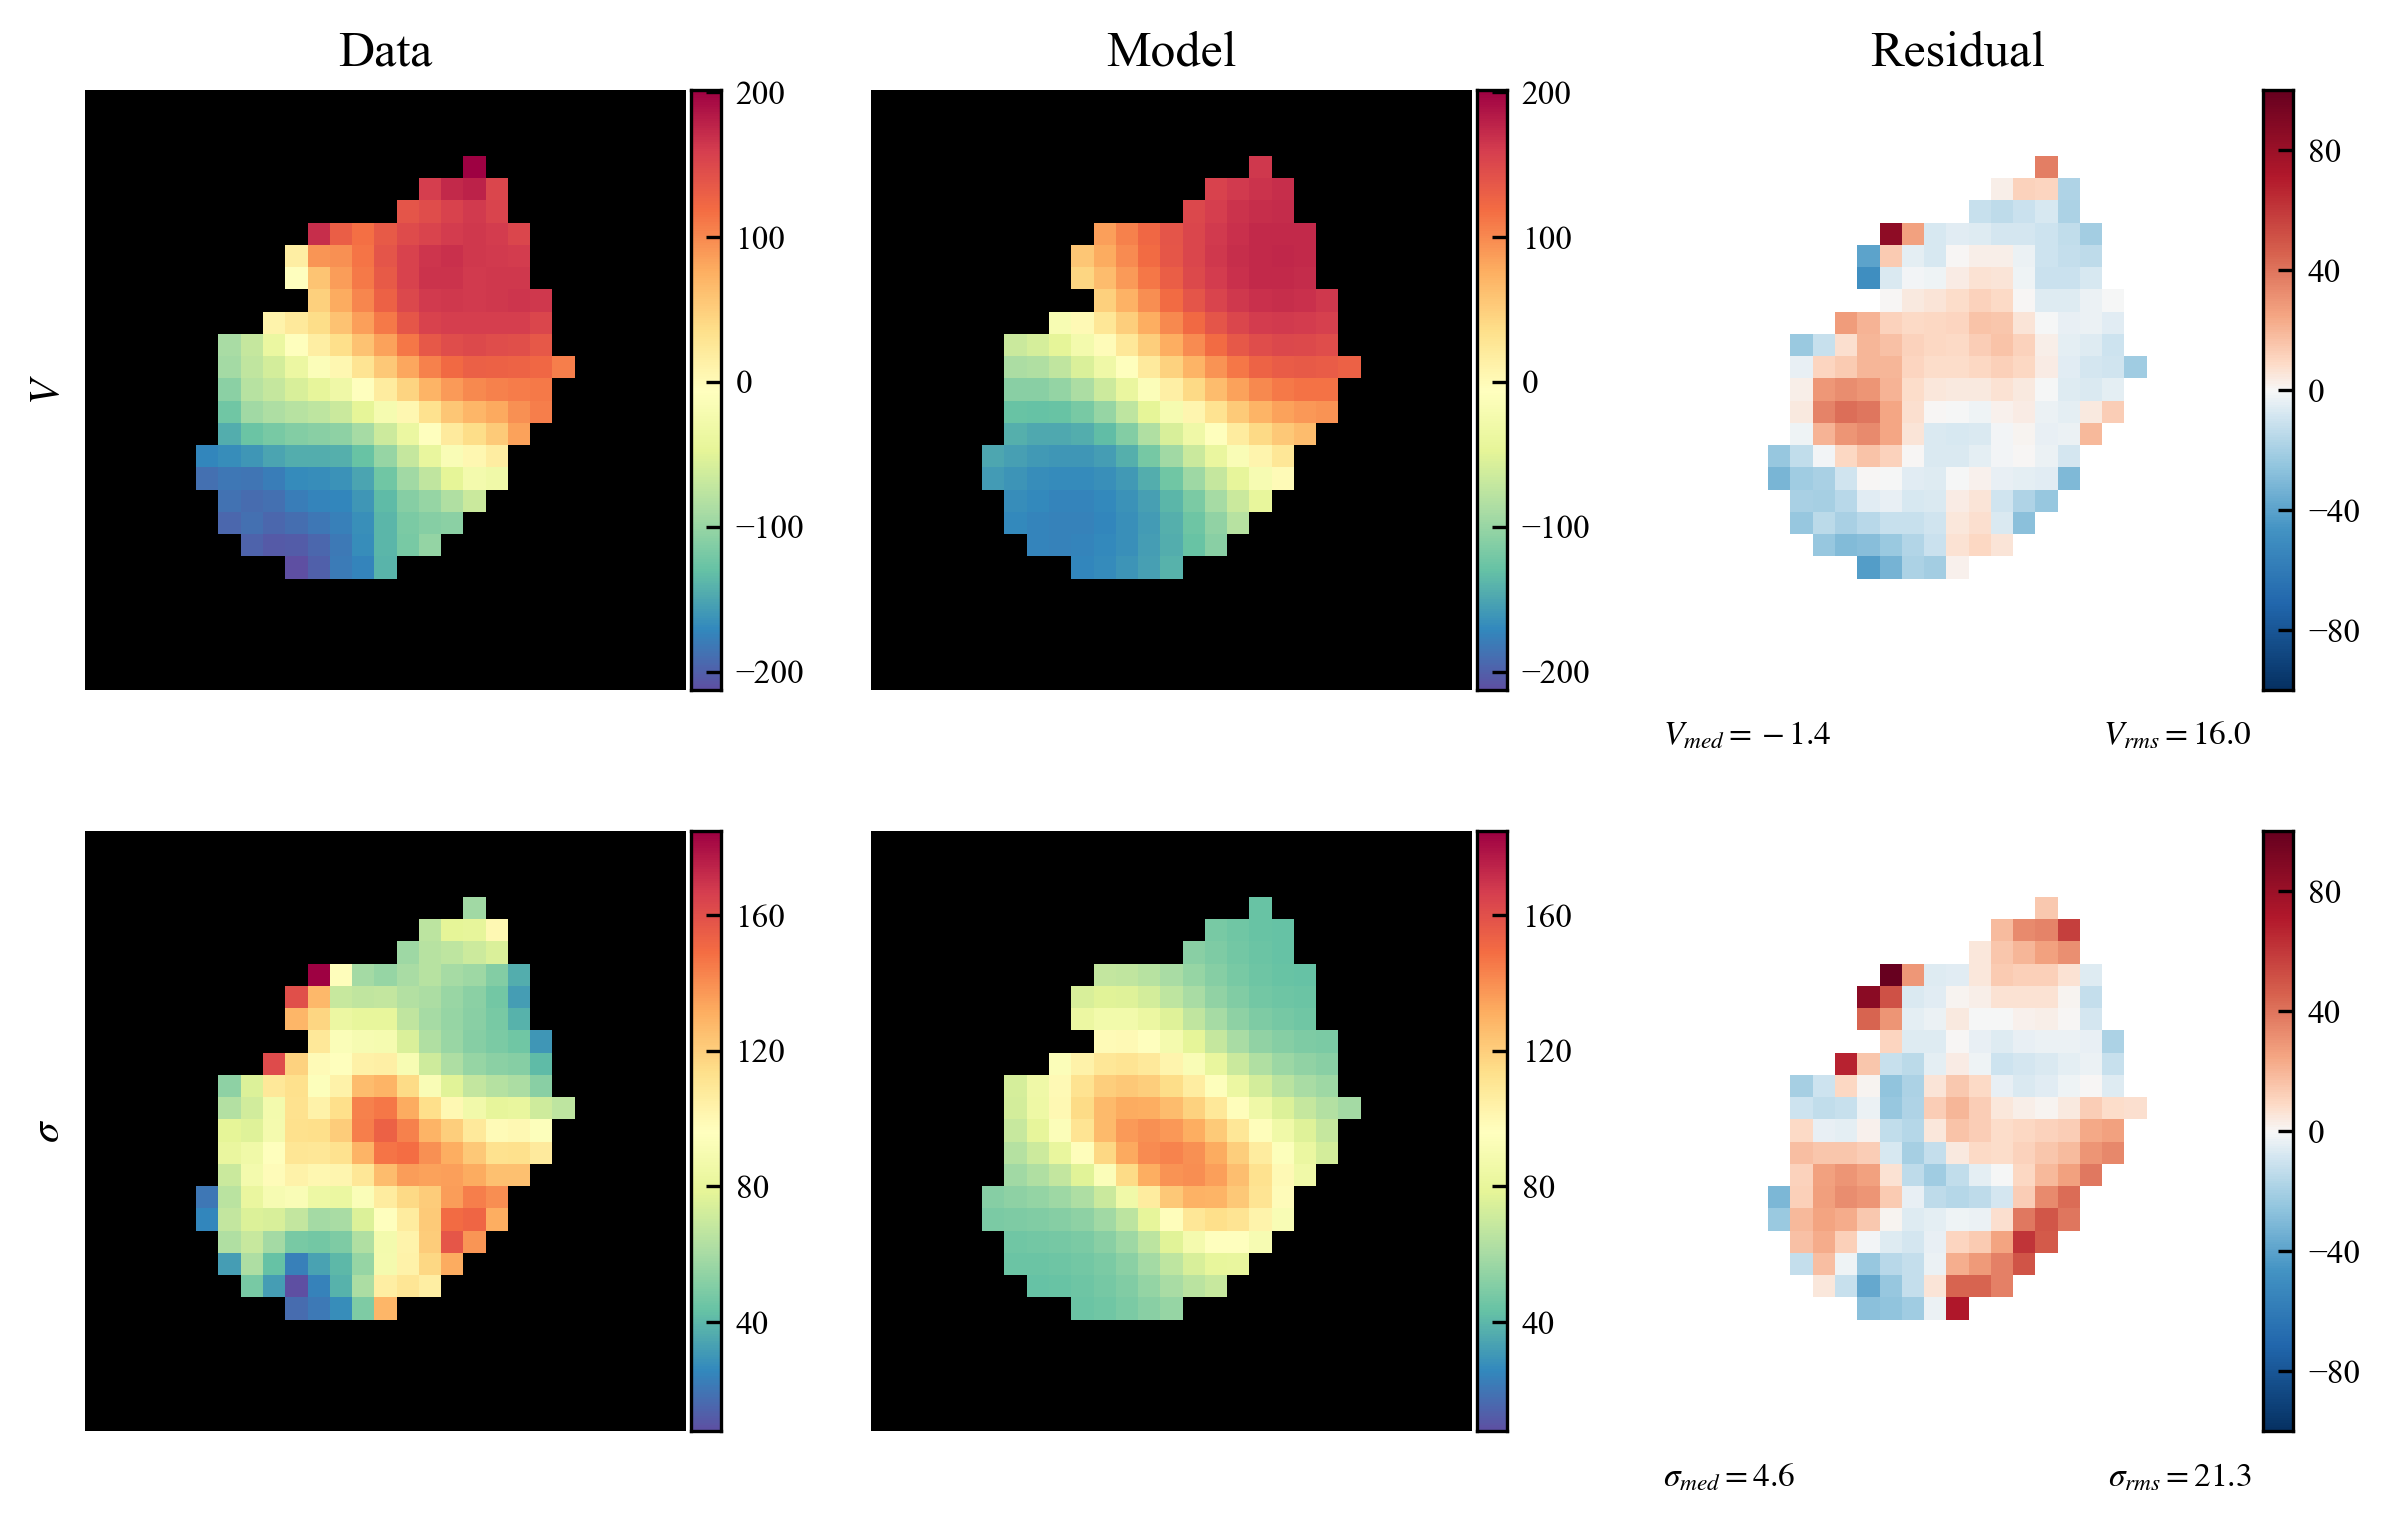

In [20]:
# Look at best-fit:
filepath = outdir_mpfit+"mpfit_best_fit.{}".format(plot_type)
Image(filename=filepath, width=600, height=570)

#### Reload the galaxy, results files:

In [21]:
f_galmodel =       outdir_mpfit + 'galaxy_model.pickle'
f_mpfit_results =  outdir_mpfit + 'mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting_mpfit(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results)

#### Plot the best-fit results:

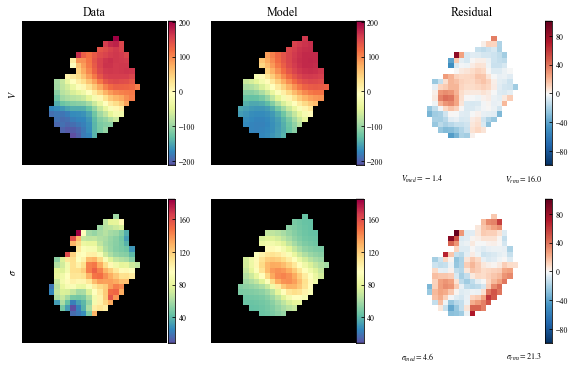

In [22]:
mpfit_results.plot_results(gal, fitdispersion=fitdispersion, 
                          oversample=oversample,
                          f_plot_bestfit=None)

### Print results report:

In [23]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-18 05:00:21.672764


Fitting method: MPFIT

pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       10.8565  +/-   0.1341
    r_eff_disk        1.8446  +/-   0.0374

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.1641  +/-   0.0192

    mvirial          13.1073  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           41.5044  +/-   0.9403
-----------
 zheightgaus
    sigmaz            0.3133  [TIED]
-----------
 geom
    inc              37.6309  +/-   7.0096
    xshift            0.0961  +/-   0.0208
    yshift           -0.1072  +/-   0.0224
    vel_shift        23.6101  +/-   0.4981

    pa              142.0000  [FIXED]

-----------
Adiabatic contraction: False

-----------


### Or save results report to file:

In [24]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

## MCMC Fitting

##### Get a clean copy of model, instrument

In [25]:
gal            = galaxy.Galaxy(z=1.613, name='GS4_43501')
gal.data       = copy.deepcopy(data2d)
gal.model      = copy.deepcopy(mod_set)
gal.instrument = copy.deepcopy(inst)

### MCMC fitting parameters ###

Set parameters for fitting: 
   - Passing options to `emcee`
   - Other calculation options

In [26]:
# Options passed to emcee
nwalkers = 1000
ncpus = 4
scale_param_a = 3
nburn = 50
nsteps = 200
minaf = None
maxaf = None
neff = 10

# nwalkers = 500
# ncpus = 4
# scale_param_a = 3
# nburn = 50
# nsteps = 50
# minaf = None
# maxaf = None
# neff = 10

# # SHORT TEST:
# nwalkers = 20
# ncpus = 4
# scale_param_a = 3
# nburn = 2
# nsteps = 20 #5
# minaf = None
# maxaf = None
# neff = 10

# Other options
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

blob_name = 'mvirial'    # Also save 'blob' values of Mvirial, calculated at every chain step

outdir_mcmc = outdir + 'MCMC/'

# Choose plot filetype:
plot_type = 'png'

-------

## Run `Dysmalpy` fitting: MCMC

In [27]:
mcmc_results = fitting.fit(gal, nWalkers=nwalkers, nCPUs=ncpus,
                               scale_param_a=scale_param_a, nBurn=nburn,
                               nSteps=nsteps, minAF=minaf, maxAF=maxaf,
                               nEff=neff, do_plotting=do_plotting,
                               oversample=oversample, outdir=outdir_mcmc,
                               fitdispersion=fitdispersion,
                               blob_name=blob_name, 
                               plot_type=plot_type)

INFO:DysmalPy:Making path=/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_2D/MCMC/
INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 with MCMC
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 1000
INFO:DysmalPy:lnlike: red_chisq=False
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: mvirial
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a173747b8>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
Burn-in:
Start: 2020-10-18 05:00:22.097654

INFO:DysmalPy: k=0, time.time=2020-10-18 05:00:22.098821, a_frac=nan
INFO:DysmalPy: k=1, time.time=2020-10-18 06:40:49.347444, a_frac=0.257
INFO:DysmalPy: k=2, time.time=2020-10-18 07:12:22.139223, a_frac=0.2655
INFO:DysmalPy: k=3, time.time=2020-10-18 07:43:37.953481, a_frac=0.2626666666666666
INFO:DysmalPy: k=4, time.time=2020-10-18 08:17:47.352364, a_frac=0.26475
INFO:DysmalPy: k=5, time.time=2020-10-18 08:55:10.903272, a_frac=0.26720000000000005
INFO:DysmalPy: k=6, time.time=20

INFO:DysmalPy: 23: Chain too short for acor to run
INFO:DysmalPy:ii=24, a_frac=0.23916 time.time()=2020-10-19 20:57:46.043434
INFO:DysmalPy: 24: Chain too short for acor to run
INFO:DysmalPy:ii=25, a_frac=0.2395769230769231 time.time()=2020-10-19 21:37:00.193199
INFO:DysmalPy: 25: Chain too short for acor to run
INFO:DysmalPy:ii=26, a_frac=0.24007407407407408 time.time()=2020-10-19 22:14:34.820591
INFO:DysmalPy: 26: Chain too short for acor to run
INFO:DysmalPy:ii=27, a_frac=0.2399642857142857 time.time()=2020-10-19 22:50:25.240563
INFO:DysmalPy: 27: Chain too short for acor to run
INFO:DysmalPy:ii=28, a_frac=0.23875862068965517 time.time()=2020-10-19 23:28:35.949902
INFO:DysmalPy: 28: Chain too short for acor to run
INFO:DysmalPy:ii=29, a_frac=0.2376 time.time()=2020-10-20 00:08:36.209642
INFO:DysmalPy: 29: Chain too short for acor to run
INFO:DysmalPy:ii=30, a_frac=0.2376774193548387 time.time()=2020-10-20 00:45:56.340079
INFO:DysmalPy: 30: Chain too short for acor to run
INFO:Dysmal

KeyboardInterrupt: 

### Examine MCMC results

In [ ]:
# Look at trace:
filepath = outdir_mcmc+"mcmc_trace.{}".format(plot_type)
Image(filepath, width=600, height=400)

In [ ]:
# Look at best-fit:
filepath = outdir_mcmc+"mcmc_best_fit.{}".format(plot_type)
Image(filepath, width=600, height=570)

In [ ]:
# Look at corner:
filepath = outdir_mcmc+"mcmc_param_corner.{}".format(plot_type)
Image(filepath, width=570, height=620)

---------

### Load and examine results:

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)
  - ...

#### Reload the galaxy, results files:

In [ ]:
f_galmodel = outdir_mcmc + 'galaxy_model.pickle'
f_mcmc_results =  outdir_mcmc + 'mcmc_results.pickle'

gal, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_mcmc_results=f_mcmc_results)

#### If necessary, also reload the sampler chain:

In [ ]:
f_sampler =  outdir_mcmc + 'mcmc_sampler.pickle'
mcmc_results.reload_sampler(filename=f_sampler)

#### Plot the best-fit results:

In [ ]:
mcmc_results.plot_results(gal, fitdispersion=fitdispersion, 
                          oversample=oversample,
                          f_plot_param_corner=None, 
                          f_plot_bestfit=None, f_plot_trace=None)

### Print results report:

In [ ]:
# Print report
print(mcmc_results.results_report(gal=gal))

### Or save results report to file:

In [ ]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
mcmc_results.results_report(gal=gal, filename=f_mcmc_report)

------